<table align="left">
    <td>
        <a href="https://colab.research.google.com/github/vigneshk01/style-transfer-using-GAN/blob/master/style-transfer-using-gan-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
    </td>
    <td>
        <a href="https://www.kaggle.com/code/vigneshk01/style-transfer-using-cyclegan-final/edit" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/></a>
    </td>
</table>

## Style Transfer Using GAN (CycleGAN)

### Variables, Hyperparamaters and libraries import

In [38]:
# Environment selection

'''
PLATFORM = 'collab'
from google.colab import drive
drive.mount('/content/drive')
'''

PLATFORM = 'kaggle'
# PLATFORM = ''

In [39]:
# Install required packages 

# %pip install -r requirements.txt
# %pip install git+https://github.com/tensorflow/docs

import importlib.util
import subprocess
import sys

# Check if a package is already available and if not install
def verify_custom_package(package_name, repo_url):
    if importlib.util.find_spec(package_name) is None:
        print(f"{package_name} is not installed. Installing from {repo_url}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", repo_url])
    else:
        print(f"{package_name} is already installed.")

verify_custom_package("tensorflow_docs", "git+https://github.com/tensorflow/docs")

tensorflow_docs is already installed.


In [40]:
# import required packages
import os
import time
import glob
import pickle
import imageio
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import asarray
from skimage.io import imread

import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow_docs.vis.embed as embed
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import img_to_array, load_img, array_to_img

# Check for GPU acceleration
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
# Configure source folder paths based on environment selection 
if PLATFORM == 'collab':
    SOURCE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/projects/Style-Transfer-using-GAN/Source/'
    T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
    T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'
    OUTPUT_FOLDER = './Output/'
elif PLATFORM == 'kaggle':
    SOURCE_FOLDER = '/kaggle/input/cyclegan-dataset/CycleGAN_Kaggle/'
    T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
    T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'
    OUTPUT_FOLDER = './Output/'
else:
    SOURCE_FOLDER = './Source/'
    T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
    T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'
    OUTPUT_FOLDER = './Output/'

TIMESTAMP = str(time.strftime('%Y%m%d%H%M%S')) 
TEMP_FOLDER = OUTPUT_FOLDER + TIMESTAMP + '/'

if os.path.exists(OUTPUT_FOLDER):
    if os.path.exists(TEMP_FOLDER) != True:
        os.mkdir(TEMP_FOLDER)
else:
    os.mkdir(OUTPUT_FOLDER)
    os.mkdir(TEMP_FOLDER)

# Define Hyperparamters and Environment variables
EPOCHS = 50
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
BUFFER_SIZE = 1000
RESTORE_CHECKPOINT = False 

### Data Initialization

(43, 256, 256, 1)
(46, 256, 256, 1)


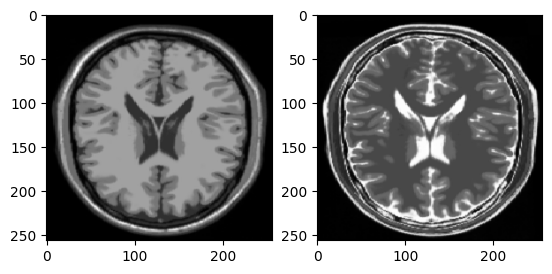

In [42]:
# load and resize images
def load_images(path, size=(IMG_HEIGHT, IMG_WIDTH)):
    images = glob.glob(path+'*.png')
    data_list = list()

    for filename in images:
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store the data
        data_list.append(pixels)
    return asarray(data_list)

# load images from source folder
t1_images = load_images(T1_FOLDER)
t2_images = load_images(T2_FOLDER)

#convert all the images from rgb to graayscale
tr1_data = tf.image.rgb_to_grayscale(t1_images)
tr2_data = tf.image.rgb_to_grayscale(t2_images)


tr1_dt= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr2_dt= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))

print(tr1_data.shape)
print(tr2_data.shape)

# Check the T1 and T2 type images
fig, axs = plt.subplots(1,2)
axs[0].imshow(tr1_data[0], cmap='gray')
axs[1].imshow(tr2_data[0], cmap='gray')
plt.show();

### Image Preprocessing

#### Image Normalization, Shuffling and Batch Processing

In [43]:
# perform pixel normalization on input images
def normalize(image):
    image =  tf.cast(image, tf.float32)
    image= (image / 127.5) - 1
    return image

# augment images with random flip left right
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

AUTOTUNE = tf.data.experimental.AUTOTUNE

# tr1 = tr1_dt.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# tr2 = tr2_dt.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tr1 = tr1_dt.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tr2 = tr2_dt.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

sample_t1_data = next(iter(tr1))
sample_t2_data = next(iter(tr2))

#### Augmentation Tryouts

In [44]:
#Simulates thermal/electronic noise in scanners
def add_gaussian_noise(image, mean=0.0, stddev=15.0):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    noisy_image = tf.clip_by_value(image + noise, 0.0, 255.0)
    return noisy_image

# Mimics scanner calibration issues
def intensity_shift(image, shift_range=30):
    shift = tf.random.uniform([], -shift_range, shift_range, dtype=tf.float32)
    shifted_image = image + shift
    return tf.clip_by_value(shifted_image, 0.0, 255.0)


#Simulates non-uniform magnetic field causing smooth illumination bias
def intensity_gradient(image):
    height, width, _ = image.shape
    gradient = tf.linspace(0.8, 1.2, width)
    gradient = tf.reshape(gradient, (1, width, 1))
    biased_image = image * gradient
    return tf.clip_by_value(biased_image, 0.0, 255.0)

#MRI scans from different scanners may have varying contrast levels
def random_contrast(image, lower=0.7, upper=1.3):
    # Contrast variation in the range [0, 255]
    contrast_factor = tf.random.uniform([], lower, upper)
    contrast_image = image * contrast_factor
    return tf.clip_by_value(contrast_image, 0.0, 255.0)

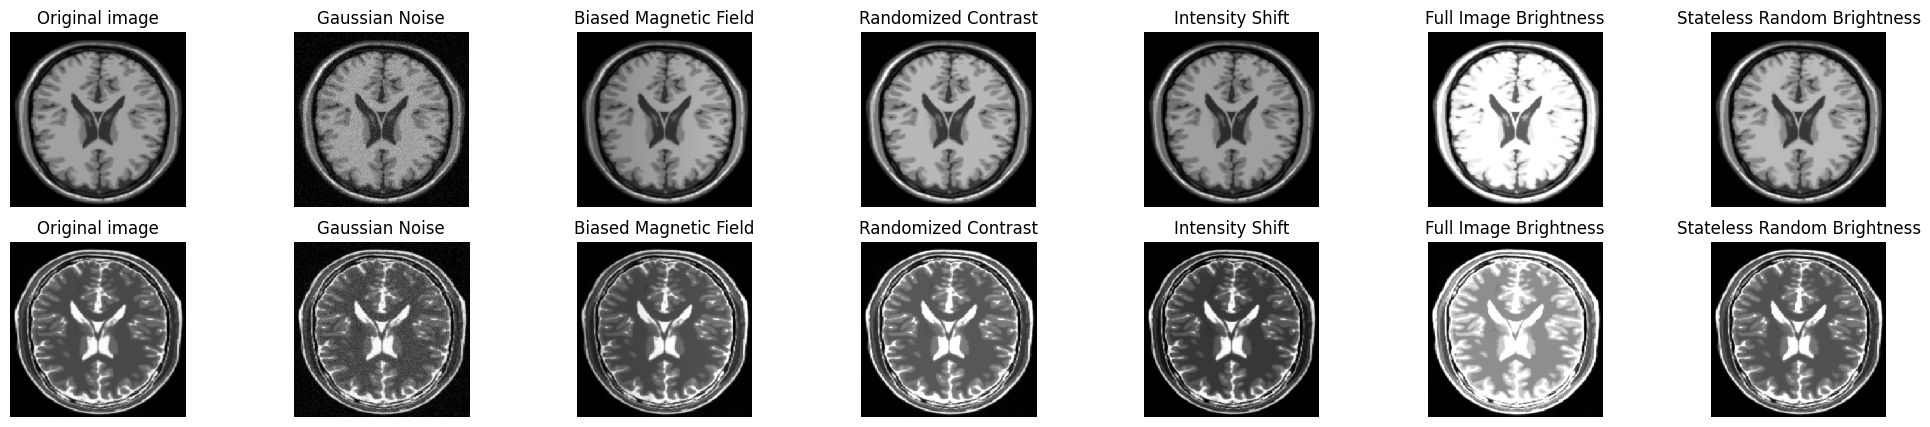

In [45]:
# Augment and Visualize T1 and T2 samples
seed = (1, 2)
fig, axs = plt.subplots(2, 7, figsize=(25, 5))

def augment_sample_images(images):
    for idx, img in enumerate(images):
        axs[idx][0].imshow(img, cmap="gray")
        axs[idx][0].set_title('Original image')
        axs[idx][1].imshow(add_gaussian_noise(img), cmap="gray")
        axs[idx][1].set_title('Gaussian Noise')
        axs[idx][2].imshow(intensity_gradient(img), cmap="gray")
        axs[idx][2].set_title('Biased Magnetic Field')
        axs[idx][3].imshow(random_contrast(img), cmap="gray")
        axs[idx][3].set_title('Randomized Contrast')
        axs[idx][4].imshow(intensity_shift(img), cmap="gray")
        axs[idx][4].set_title('Intensity Shift')
        axs[idx][5].imshow(tf.image.adjust_brightness(array_to_img(img), delta=0.5), cmap="gray")
        axs[idx][5].set_title('Full Image Brightness')
        axs[idx][6].imshow(tf.image.stateless_random_brightness(array_to_img(img),0.2,seed = (1, 2)), cmap='gray')
        axs[idx][6].set_title('Stateless Random Brightness')
    
    for ax in axs:
        for a in ax:
            a.axis('off')
    
    plt.show();
        
img_lst = [tr1_data[0], tr2_data[0]]
augment_sample_images(img_lst)

### Loss Functions & Optimizer

In [46]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Model Building

#### Instance Normalization

In [47]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__() # calling parent's init
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset
    
    def get_config(self):
        # Add epsilon to the config dictionary for deserialization
        config = super(InstanceNormalization, self).get_config()
        config.update({"epsilon": self.epsilon})
        return config

#### Downsampling and Upsampling

In [51]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()

    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())

    # Add Leaky Relu Activation
    # result.add(tf.keras.layers.LeakyReLU())
    result.add(tf.keras.layers.LeakyReLU(negative_slope = 0.2))
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()

    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    # Add Normalization Layer
    result.add(InstanceNormalization())

    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Generator

In [52]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():

    down_stack = [
        downsample(64, 4, True),
        downsample(128, 4, True),
        downsample(256, 4, True),
    ]
    
    up_stack = [
        upsample(256, 4, False),
        upsample(128, 4, False),
        upsample(64, 4, False)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [53]:
generator_g = unet_generator()
generator_f = unet_generator()
generator_g.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_12             │ (None, 128, 128, 64)   │          1,152 │ input_layer_12[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_13             │ (None, 64, 64, 128)    │        131,328 │ sequential_12[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_14             │ (None, 32, 32, 256)    │        524,800 │ sequential_13[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_15             │ (None, 64, 64, 256)    │      1,049,088 │ sequential_14[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 128, 128, 192)  │              0 │ sequential_15[0][0],   │
│ (Concatenate)             │                        │                │ sequential_13[0][0],   │
│                           │                        │                │ sequential_16[0][0],   │
│                           │                        │                │ sequential_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_16             │ (None, 128, 128, 128)  │        786,688 │ concatenate_2[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_11       │ (None, 256, 256, 1)    │          3,073 │ concatenate_2[1][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,496,129 (9.52 MB)

 Trainable params: 2,496,129 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

#### Discriminator

In [54]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
    x = inp

    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    down3 = downsample(256, 4)(down2)

    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 10, 10, 128)

    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)
    # conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer,
    #                               use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)

    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [55]:
discriminator_x = discriminator()
discriminator_y = discriminator()
discriminator_x.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_24 (Sequential)           │ (None, 128, 128, 64)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_25 (Sequential)           │ (None, 64, 64, 128)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_26 (Sequential)           │ (None, 32, 32, 256)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 31, 31, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_26            │ (None, 31, 31, 512)         │           1,024 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 31, 31, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 33, 33, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 30, 30, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,763,521 (10.54 MB)

 Trainable params: 2,763,521 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1746868822.689158      31 cuda_dnn.cc:529] Loaded cuDNN version 90300


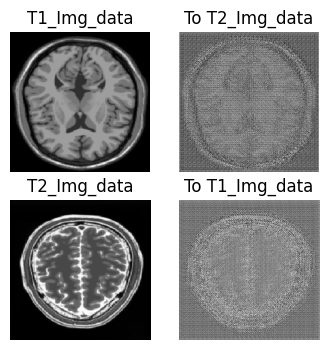

In [56]:
# trial run
to_t2_img_data = generator_g(sample_t1_data)
to_t1_img_data = generator_f(sample_t2_data)
plt.figure(figsize=(4, 4))

imgs = [sample_t1_data, to_t2_img_data, sample_t2_data, to_t1_img_data]
title = ['T1_Img_data', 'To T2_Img_data', 'T2_Img_data', 'To T1_Img_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0], cmap='gray')
    plt.axis('off')
plt.show();

### Model Training

#### Checkpoint Initialization

In [57]:
checkpoint_path = TEMP_FOLDER +"Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint and RESTORE_CHECKPOINT:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [58]:
def generate_images(model1, test_input1, model2, test_input2, epoch):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(TEMP_FOLDER +'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show();

In [59]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_id_loss = identity_loss(real_y, same_y) + identity_loss(real_x, same_x)

        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        'gen_g_loss': gen_g_loss, 'gen_f_loss': gen_f_loss,
        'cycle_loss': total_cycle_loss, 'identity_loss': total_id_loss,
        'disc_x_loss': disc_x_loss, 'disc_y_loss': disc_y_loss
    }


Epoch 1/50
Avg Losses -> GenG: 0.9754, GenF: 0.9666, Cycle: 3.4725, Identity: 0.1873, DiscX: 0.6979, DiscY: 0.6919


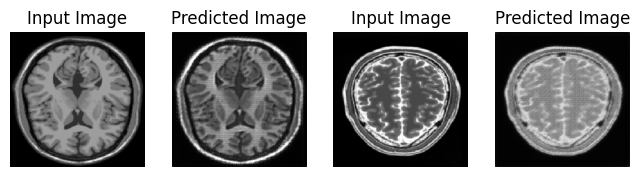

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-1

Epoch 2/50
Avg Losses -> GenG: 1.0616, GenF: 1.0653, Cycle: 1.6864, Identity: 0.1055, DiscX: 0.5470, DiscY: 0.5585


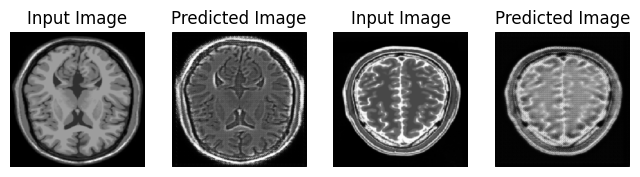

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-2

Epoch 3/50
Avg Losses -> GenG: 1.0590, GenF: 1.0397, Cycle: 1.7529, Identity: 0.1313, DiscX: 0.5624, DiscY: 0.5425


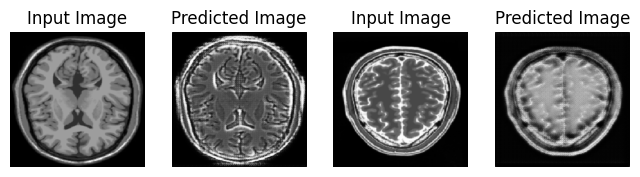

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-3

Epoch 4/50
Avg Losses -> GenG: 1.0234, GenF: 0.9521, Cycle: 1.6497, Identity: 0.1420, DiscX: 0.6394, DiscY: 0.5786


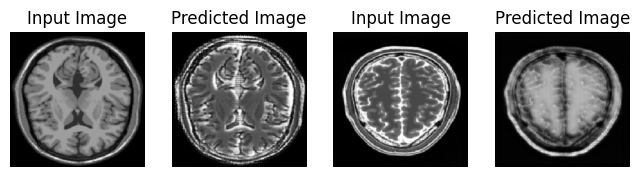

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-4

Epoch 5/50
Avg Losses -> GenG: 0.9506, GenF: 0.9391, Cycle: 1.6387, Identity: 0.1531, DiscX: 0.6005, DiscY: 0.6078


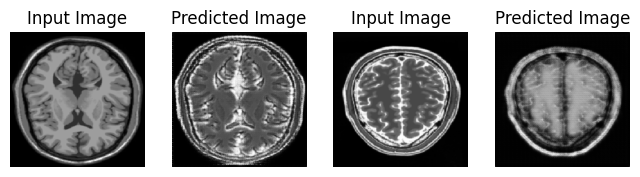

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-5

Epoch 6/50
Avg Losses -> GenG: 0.9363, GenF: 0.9034, Cycle: 1.5174, Identity: 0.1484, DiscX: 0.6269, DiscY: 0.6013


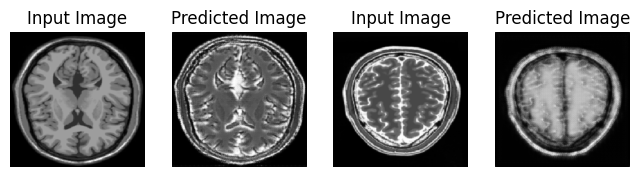

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-6

Epoch 7/50
Avg Losses -> GenG: 0.9546, GenF: 0.9289, Cycle: 1.5122, Identity: 0.1428, DiscX: 0.6042, DiscY: 0.5978


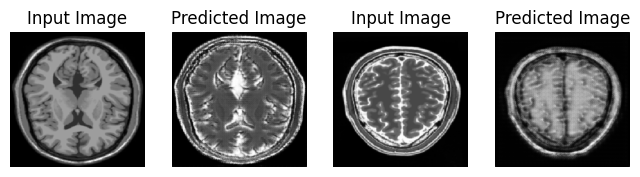

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-7

Epoch 8/50
Avg Losses -> GenG: 0.9609, GenF: 0.9298, Cycle: 1.4167, Identity: 0.1377, DiscX: 0.6065, DiscY: 0.5795


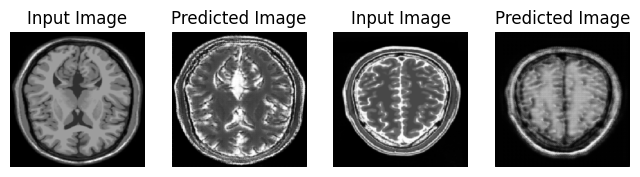

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-8

Epoch 9/50
Avg Losses -> GenG: 0.9879, GenF: 1.0243, Cycle: 1.4411, Identity: 0.1368, DiscX: 0.6012, DiscY: 0.6309


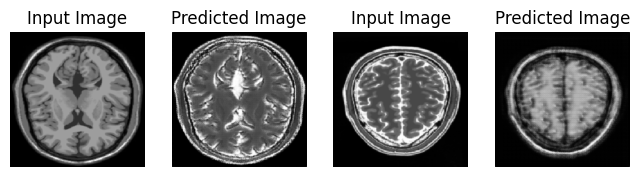

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-9

Epoch 10/50
Avg Losses -> GenG: 0.9357, GenF: 1.0138, Cycle: 1.3264, Identity: 0.1344, DiscX: 0.5949, DiscY: 0.5696


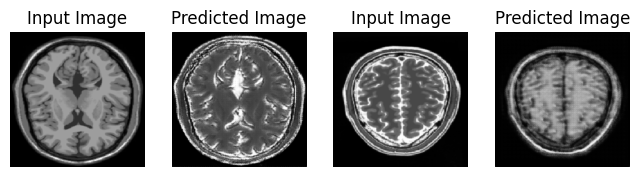

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-10

Epoch 11/50
Avg Losses -> GenG: 0.9900, GenF: 1.1511, Cycle: 1.4266, Identity: 0.1413, DiscX: 0.5507, DiscY: 0.5964


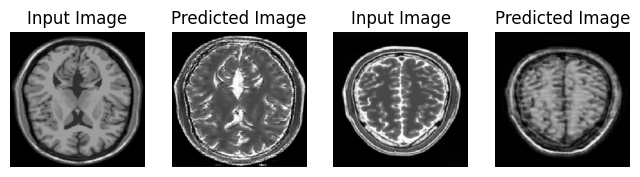

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-11

Epoch 12/50
Avg Losses -> GenG: 1.0508, GenF: 1.2252, Cycle: 1.4501, Identity: 0.1453, DiscX: 0.5439, DiscY: 0.5909


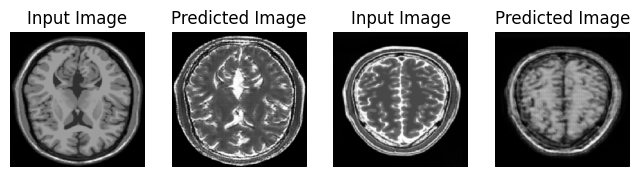

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-12

Epoch 13/50
Avg Losses -> GenG: 1.4700, GenF: 1.4459, Cycle: 1.6128, Identity: 0.1649, DiscX: 0.4834, DiscY: 0.4849


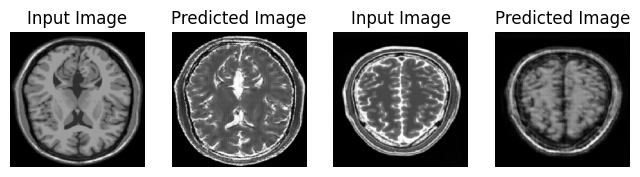

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-13

Epoch 14/50
Avg Losses -> GenG: 2.0394, GenF: 1.5566, Cycle: 1.7360, Identity: 0.1706, DiscX: 0.4799, DiscY: 0.3577


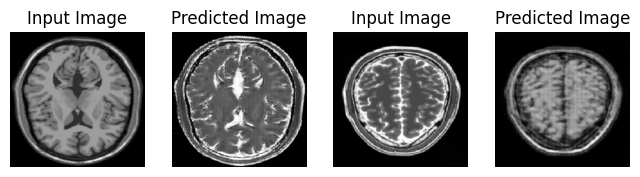

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-14

Epoch 15/50
Avg Losses -> GenG: 2.2561, GenF: 1.7279, Cycle: 1.7349, Identity: 0.1788, DiscX: 0.4598, DiscY: 0.3390


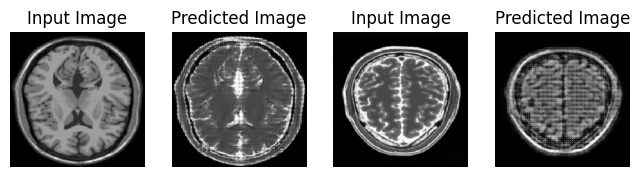

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-15

Epoch 16/50
Avg Losses -> GenG: 2.7831, GenF: 1.4030, Cycle: 1.7060, Identity: 0.2019, DiscX: 0.5513, DiscY: 0.2958


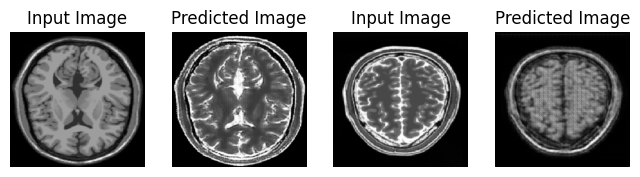

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-16

Epoch 17/50
Avg Losses -> GenG: 3.2997, GenF: 1.6106, Cycle: 1.7311, Identity: 0.2032, DiscX: 0.4049, DiscY: 0.1274


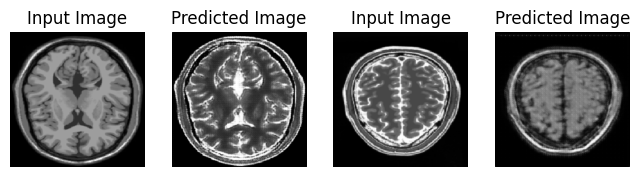

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-17

Epoch 18/50
Avg Losses -> GenG: 3.1259, GenF: 1.6242, Cycle: 1.6704, Identity: 0.2054, DiscX: 0.4641, DiscY: 0.2944


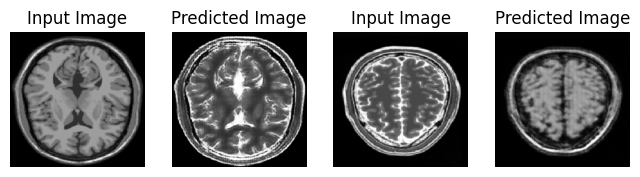

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-18

Epoch 19/50
Avg Losses -> GenG: 2.8724, GenF: 1.6450, Cycle: 1.5811, Identity: 0.2065, DiscX: 0.4772, DiscY: 0.4405


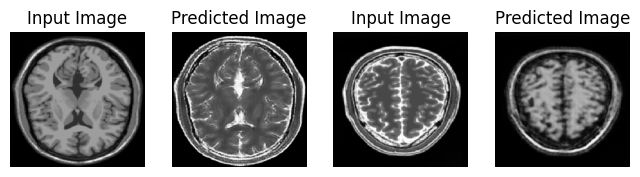

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-19

Epoch 20/50
Avg Losses -> GenG: 0.8625, GenF: 1.7248, Cycle: 1.3165, Identity: 0.1897, DiscX: 0.4008, DiscY: 0.6501


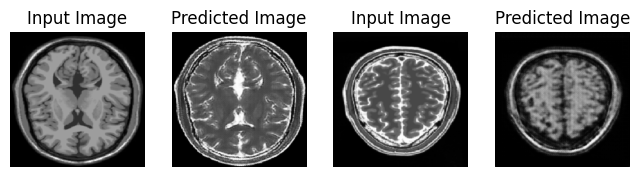

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-20

Epoch 21/50
Avg Losses -> GenG: 1.6228, GenF: 1.7415, Cycle: 1.4112, Identity: 0.1888, DiscX: 0.4223, DiscY: 0.5351


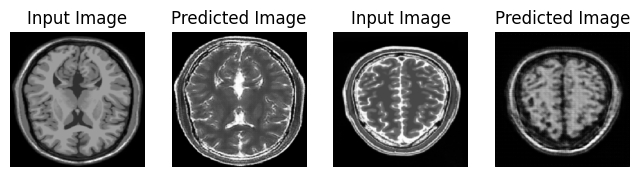

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-21

Epoch 22/50
Avg Losses -> GenG: 3.0343, GenF: 2.0857, Cycle: 1.5319, Identity: 0.1888, DiscX: 0.4017, DiscY: 0.1369


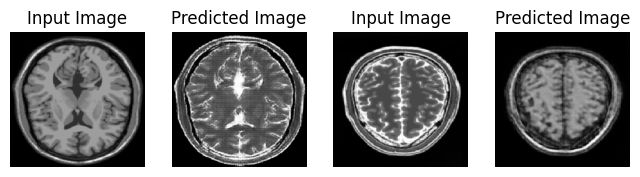

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-22

Epoch 23/50
Avg Losses -> GenG: 3.3634, GenF: 2.4024, Cycle: 1.6693, Identity: 0.2152, DiscX: 0.3208, DiscY: 0.2048


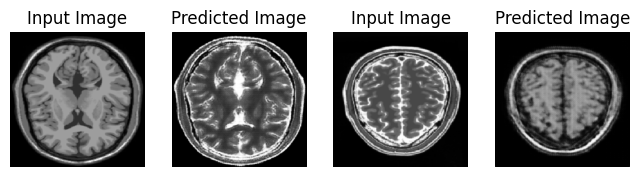

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-23

Epoch 24/50
Avg Losses -> GenG: 3.6659, GenF: 1.6780, Cycle: 1.5746, Identity: 0.1990, DiscX: 0.4894, DiscY: 0.1284


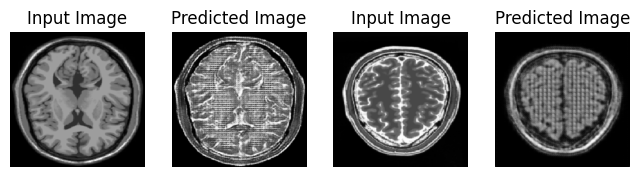

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-24

Epoch 25/50
Avg Losses -> GenG: 3.9243, GenF: 3.7135, Cycle: 1.7826, Identity: 0.2241, DiscX: 0.1123, DiscY: 0.1044


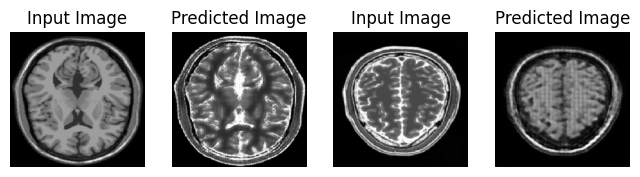

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-25

Epoch 26/50
Avg Losses -> GenG: 4.8294, GenF: 3.0809, Cycle: 1.8504, Identity: 0.2347, DiscX: 0.2631, DiscY: 0.0507


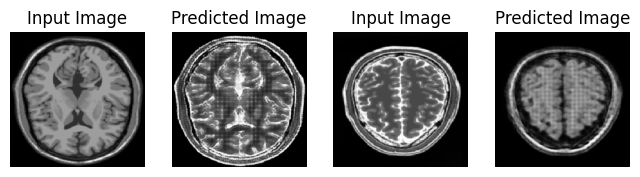

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-26

Epoch 27/50
Avg Losses -> GenG: 5.5733, GenF: 1.5623, Cycle: 1.6714, Identity: 0.2165, DiscX: 0.6422, DiscY: 0.0101


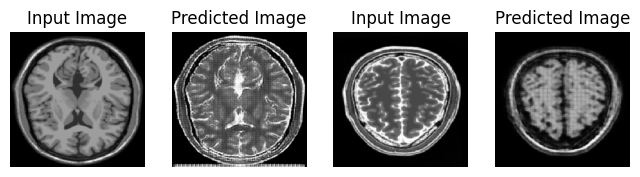

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-27

Epoch 28/50
Avg Losses -> GenG: 4.7369, GenF: 1.5815, Cycle: 1.8015, Identity: 0.2219, DiscX: 0.4815, DiscY: 0.0223


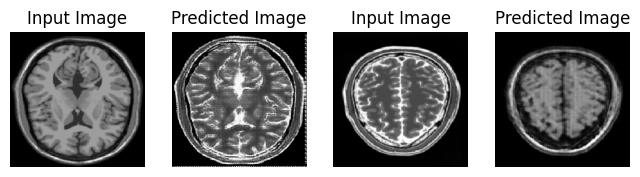

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-28

Epoch 29/50
Avg Losses -> GenG: 5.8136, GenF: 1.7665, Cycle: 1.7508, Identity: 0.2180, DiscX: 0.4240, DiscY: 0.0215


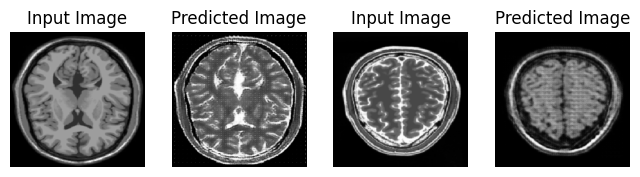

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-29

Epoch 30/50
Avg Losses -> GenG: 2.5704, GenF: 2.4204, Cycle: 1.5776, Identity: 0.2039, DiscX: 0.2890, DiscY: 0.6160


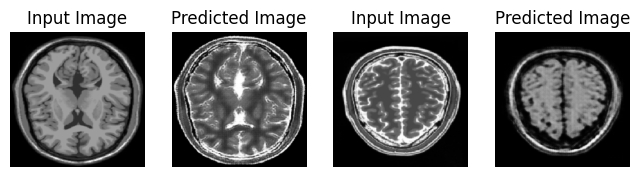

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-30

Epoch 31/50
Avg Losses -> GenG: 2.8891, GenF: 2.1100, Cycle: 1.4230, Identity: 0.1999, DiscX: 0.3442, DiscY: 0.3202


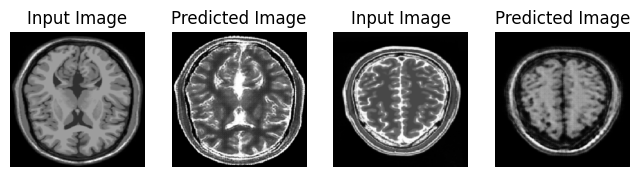

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-31

Epoch 32/50
Avg Losses -> GenG: 3.3492, GenF: 2.3784, Cycle: 1.4541, Identity: 0.1923, DiscX: 0.3329, DiscY: 0.2328


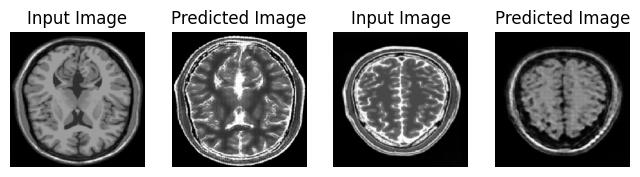

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-32

Epoch 33/50
Avg Losses -> GenG: 4.3139, GenF: 3.2584, Cycle: 1.6177, Identity: 0.1993, DiscX: 0.2111, DiscY: 0.0860


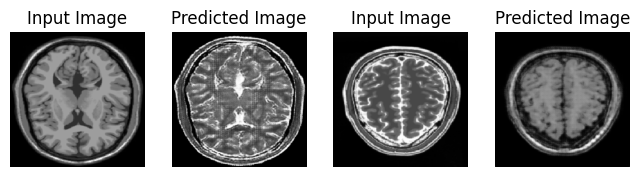

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-33

Epoch 34/50
Avg Losses -> GenG: 3.8614, GenF: 2.1430, Cycle: 1.7152, Identity: 0.1992, DiscX: 0.4071, DiscY: 0.1991


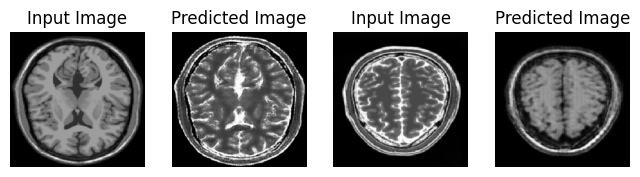

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-34

Epoch 35/50
Avg Losses -> GenG: 4.0197, GenF: 3.5319, Cycle: 2.0506, Identity: 0.1778, DiscX: 0.1391, DiscY: 0.1038


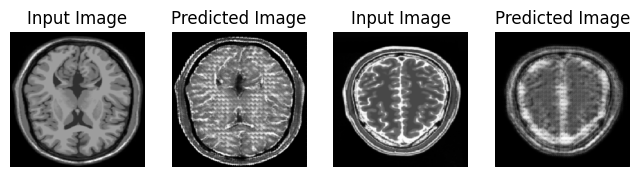

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-35

Epoch 36/50
Avg Losses -> GenG: 2.9040, GenF: 3.4075, Cycle: 1.9842, Identity: 0.1541, DiscX: 0.1499, DiscY: 0.3047


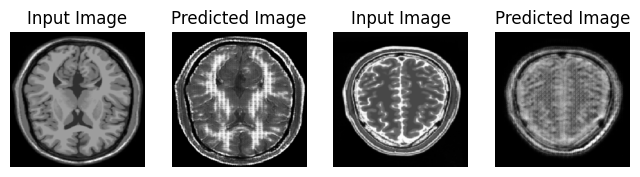

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-36

Epoch 37/50
Avg Losses -> GenG: 3.2080, GenF: 2.4474, Cycle: 1.8638, Identity: 0.1378, DiscX: 0.3458, DiscY: 0.1817


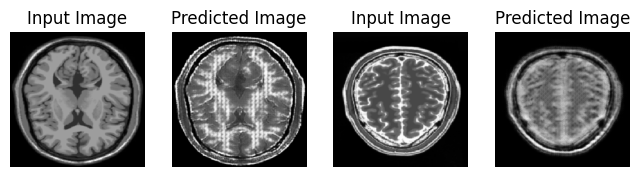

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-37

Epoch 38/50
Avg Losses -> GenG: 3.3852, GenF: 3.0060, Cycle: 1.8399, Identity: 0.1380, DiscX: 0.2999, DiscY: 0.2089


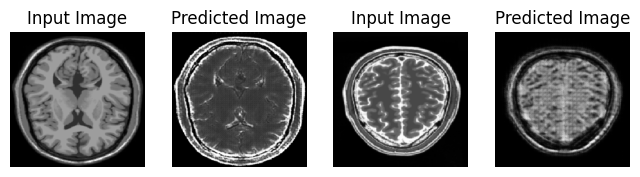

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-38

Epoch 39/50
Avg Losses -> GenG: 4.1497, GenF: 2.7731, Cycle: 2.1009, Identity: 0.2157, DiscX: 0.3949, DiscY: 0.1851


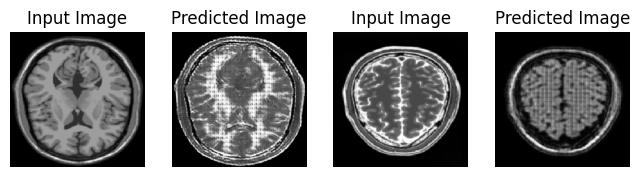

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-39

Epoch 40/50
Avg Losses -> GenG: 5.2731, GenF: 3.0813, Cycle: 2.0729, Identity: 0.1725, DiscX: 0.1973, DiscY: 0.0615


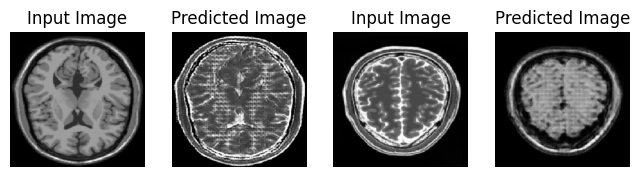

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-40

Epoch 41/50
Avg Losses -> GenG: 4.7651, GenF: 2.8476, Cycle: 2.1509, Identity: 0.1961, DiscX: 0.2703, DiscY: 0.0843


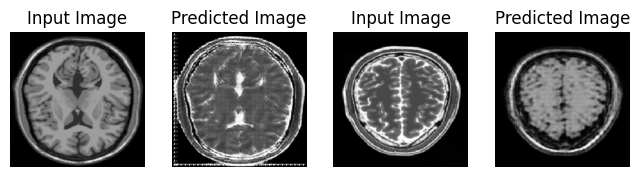

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-41

Epoch 42/50
Avg Losses -> GenG: 5.8365, GenF: 2.8108, Cycle: 1.8621, Identity: 0.2040, DiscX: 0.3029, DiscY: 0.0855


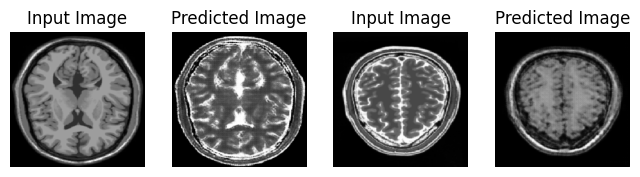

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-42

Epoch 43/50
Avg Losses -> GenG: 4.4705, GenF: 2.9038, Cycle: 1.9969, Identity: 0.1720, DiscX: 0.2602, DiscY: 0.1223


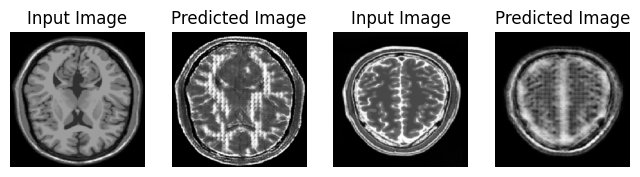

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-43

Epoch 44/50
Avg Losses -> GenG: 5.7081, GenF: 4.1993, Cycle: 1.8849, Identity: 0.1496, DiscX: 0.1708, DiscY: 0.0481


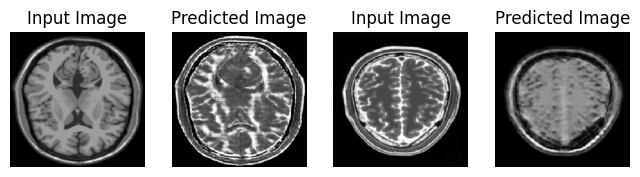

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-44

Epoch 45/50
Avg Losses -> GenG: 5.2944, GenF: 3.3761, Cycle: 1.8887, Identity: 0.1461, DiscX: 0.2856, DiscY: 0.0331


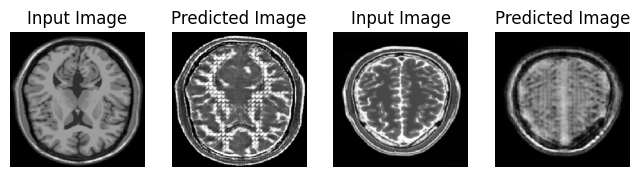

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-45

Epoch 46/50
Avg Losses -> GenG: 3.5259, GenF: 3.3834, Cycle: 2.0240, Identity: 0.1617, DiscX: 0.1979, DiscY: 0.3210


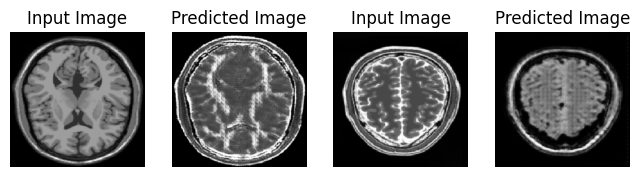

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-46

Epoch 47/50
Avg Losses -> GenG: 5.5105, GenF: 4.9294, Cycle: 2.1064, Identity: 0.1659, DiscX: 0.0958, DiscY: 0.1022


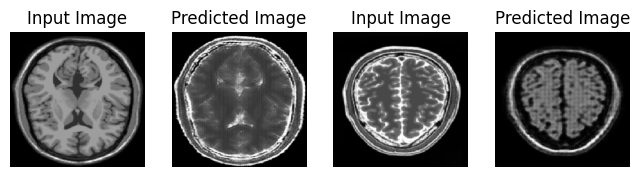

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-47

Epoch 48/50
Avg Losses -> GenG: 6.2065, GenF: 2.2872, Cycle: 1.8340, Identity: 0.2030, DiscX: 0.5050, DiscY: 0.0609


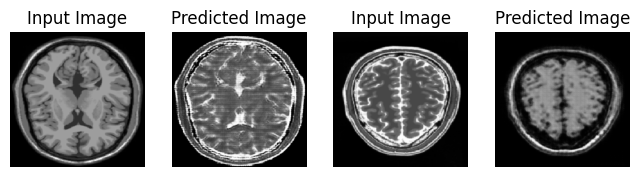

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-48

Epoch 49/50
Avg Losses -> GenG: 6.6522, GenF: 2.5589, Cycle: 1.7802, Identity: 0.1823, DiscX: 0.3544, DiscY: 0.0698


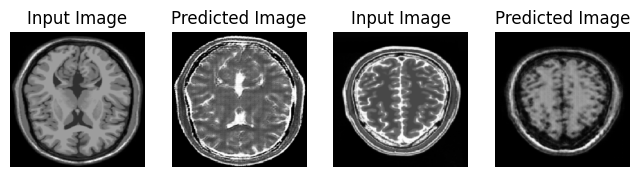

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-49

Epoch 50/50
Avg Losses -> GenG: 5.5316, GenF: 3.2329, Cycle: 1.9281, Identity: 0.1696, DiscX: 0.1514, DiscY: 0.0274


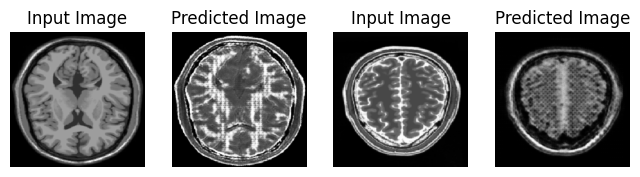

Checkpoint saved at ./Output/20250510091904/Trained_Model/ckpt-50


In [60]:
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    total_losses = {
        'gen_g_loss': 0, 'gen_f_loss': 0,
        'cycle_loss': 0, 'identity_loss': 0,
        'disc_x_loss': 0,'disc_y_loss': 0
    }

    steps = 0
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        losses = train_step(image_x, image_y)
        for key in total_losses:
            total_losses[key] += losses[key]
        steps += 1

    avg_losses = {k: v / steps for k, v in total_losses.items()}
    print(f"Avg Losses -> GenG: {avg_losses['gen_g_loss']:.4f}, GenF: {avg_losses['gen_f_loss']:.4f}, "
          f"Cycle: {avg_losses['cycle_loss']:.4f}, Identity: {avg_losses['identity_loss']:.4f}, "
          f"DiscX: {avg_losses['disc_x_loss']:.4f}, DiscY: {avg_losses['disc_y_loss']:.4f}")

    generate_images(generator_g, sample_t1_data, generator_f, sample_t2_data, epoch)
    ckpt_save_path = ckpt_manager.save()
    print('Checkpoint saved at', ckpt_save_path)

### Model Visualization

In [63]:
anim_file = TEMP_FOLDER + 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob( TEMP_FOLDER + 'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.v2.imread(filename)
    writer.append_data(image)
  image = imageio.v2.imread(filename)
  writer.append_data(image)


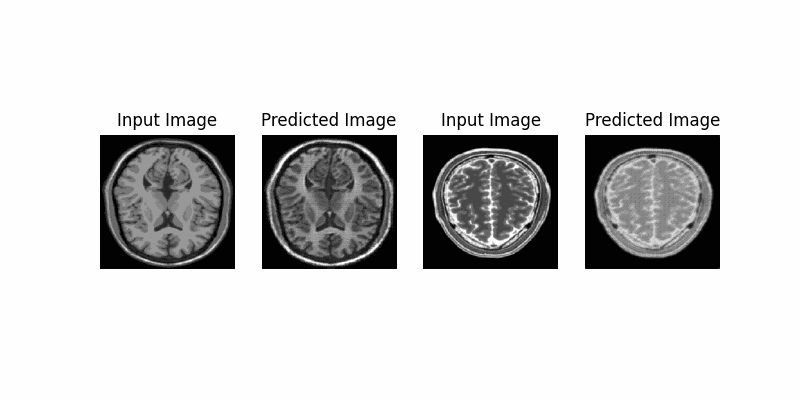

In [64]:
embed.embed_file(anim_file)

### Model Testing

In [65]:
def test_model(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(5, 5))
    display_list = [test_input[0], prediction[0]]
    title = ['Original Image', 'Predicted Image' ]
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

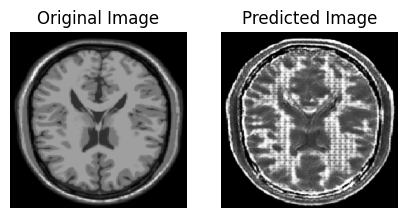

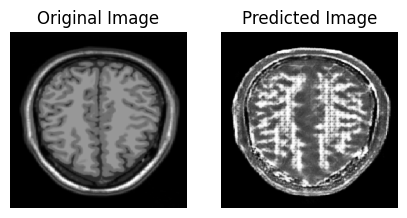

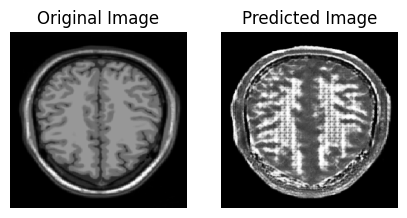

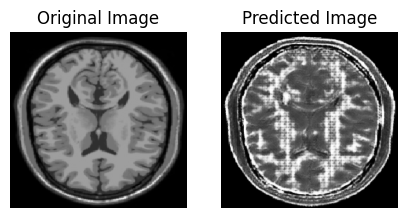

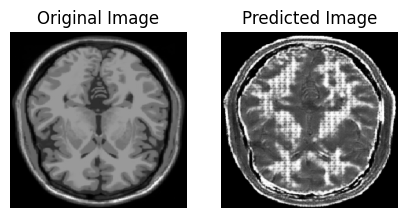

In [66]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
    test_model(generator_g, inp)

In [67]:
# print(train_step.pretty_printed_concrete_signatures())
generator_g.save( TEMP_FOLDER + 'test.keras')

Input Parameters:
  real_x (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 256, 256, 1), dtype=tf.float32, name=None)
  real_y (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 256, 256, 1), dtype=tf.float32, name=None)
Output Type:
  Dict[['gen_g_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)], ['gen_f_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)], ['cycle_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)], ['identity_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)], ['disc_x_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)], ['disc_y_loss', TensorSpec(shape=(), dtype=tf.float32, name=None)]]
Captures:
  134646756900688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134643182928528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134643182928912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134643182929488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134643182929104: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [68]:
loaded_model =  tf.keras.models.load_model(
    TEMP_FOLDER + 'test.keras',
    custom_objects={'InstanceNormalization': InstanceNormalization}
)

loaded_model.summary()

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_17', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_12'}, 'registered_name': None, 'name': 'input_layer_12', 'inbound_nodes': []}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_13'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 1]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'name': 'instance_normalization_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'epsilon': 1e-05}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 128, 128, 64]}}, {'module': 'keras.layers', 'class_name': 'LeakyReLU', 'config': {'name': 'leaky_re_lu_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'negative_slope': 0.2}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}}], 'build_input_shape': [None, 256, 256, 1]}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 1]}, 'name': 'sequential_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 1], 'dtype': 'float32', 'keras_history': ['input_layer_12', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 128, 128, 64], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_14'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'filters': 128, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'name': 'instance_normalization_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'epsilon': 1e-05}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 64, 64, 128]}}, {'module': 'keras.layers', 'class_name': 'LeakyReLU', 'config': {'name': 'leaky_re_lu_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'negative_slope': 0.2}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}}], 'build_input_shape': [None, 128, 128, 64]}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'sequential_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['sequential_12', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 64, 64, 128], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_15'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'filters': 256, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'name': 'instance_normalization_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'epsilon': 1e-05}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 32, 32, 256]}}, {'module': 'keras.layers', 'class_name': 'LeakyReLU', 'config': {'name': 'leaky_re_lu_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'negative_slope': 0.2}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}}], 'build_input_shape': [None, 64, 64, 128]}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'sequential_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['sequential_13', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 32, 32, 256], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_16'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'filters': 256, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'name': 'instance_normalization_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'epsilon': 1e-05}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 64, 64, 256]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}}], 'build_input_shape': [None, 32, 32, 256]}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'sequential_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['sequential_14', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 64, 64, 256], [None, 64, 64, 128]]}, 'name': 'concatenate_2', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['sequential_15', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['sequential_13', 0, 0]}}]], 'kwargs': {}}, {'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 128], 'dtype': 'float32', 'keras_history': ['sequential_16', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['sequential_12', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 64, 64, 384], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_17'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'filters': 128, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 384]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'name': 'instance_normalization_16', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'epsilon': 1e-05}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 128, 128, 128]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 128]}}], 'build_input_shape': [None, 64, 64, 384]}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 384]}, 'name': 'sequential_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 384], 'dtype': 'float32', 'keras_history': ['concatenate_2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2DTranspose', 'config': {'name': 'conv2d_transpose_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'filters': 1, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 192]}, 'name': 'conv2d_transpose_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 192], 'dtype': 'float32', 'keras_history': ['concatenate_2', 1, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_12', 0, 0]], 'output_layers': [['conv2d_transpose_11', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}}.

Exception encountered: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 256, 256, 1], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_13'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': [4, 4], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'tensorflow.python.ops.init_ops_v2', 'class_name': 'RandomNormal', 'config': {'mean': 0.0, 'stddev': 0.02, 'seed': None}, 'registered_name': 'RandomNormal'}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 1]}}, {'module': None, 'class_name': 'InstanceNormalization', 'config': {'name': 'instance_normalization_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'epsilon': 1e-05}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 128, 128, 64]}}, {'module': 'keras.layers', 'class_name': 'LeakyReLU', 'config': {'name': 'leaky_re_lu_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'negative_slope': 0.2}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}}], 'build_input_shape': [None, 256, 256, 1]}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 256, 1]}, 'name': 'sequential_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256, 256, 1], 'dtype': 'float32', 'keras_history': ['input_layer_12', 0, 0]}}], 'kwargs': {'mask': None}}]}.

Exception encountered: <class '__main__.InstanceNormalization'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'InstanceNormalization', 'config': {'name': 'instance_normalization_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 134646843053968}, 'epsilon': 1e-05}, 'registered_name': 'InstanceNormalization', 'build_config': {'input_shape': [None, 128, 128, 64]}}.

Exception encountered: Error when deserializing class 'InstanceNormalization' using config={'name': 'instance_normalization_12', 'trainable': True, 'dtype': 'float32', 'epsilon': 1e-05}.

Exception encountered: InstanceNormalization.__init__() got an unexpected keyword argument 'name'

In [89]:
%cd {TEMP_FOLDER}

!wget -O test1.png 'https://prod-images-static.radiopaedia.org/images/13655932/ba29d24104918a30130f4003faac71.png'
!wget -O test2.png 'https://prod-images-static.radiopaedia.org/images/13655058/2fd7c8e4fffb33a31b13858642d4e4.png'
!wget -O test3.png 'https://prod-images-static.radiopaedia.org/images/13656005/bd937738ad6223a03f8aedcf4920a7.png'
!wget -O test4.png 'https://prod-images-static.radiopaedia.org/images/13655954/90ca102c87be4f399f8266ce6d96d6.png'
!wget -O test5.png 'https://prod-images-static.radiopaedia.org/images/13656021/d022d1079185636184f1044834e3cb.png'

images = [TEMP_FOLDER+'test1.png',TEMP_FOLDER+'test2.png',TEMP_FOLDER+'test3.png',TEMP_FOLDER+'test4.png', TEMP_FOLDER+'test5.png'] 

%cd /kaggle/working/

[Errno 2] No such file or directory: './Output/20250510091904/'
/kaggle/working/Output/20250510091904
--2025-05-10 09:44:20--  https://prod-images-static.radiopaedia.org/images/13655932/ba29d24104918a30130f4003faac71.png
Resolving prod-images-static.radiopaedia.org (prod-images-static.radiopaedia.org)... 172.67.21.164, 104.22.37.235, 104.22.36.235, ...
Connecting to prod-images-static.radiopaedia.org (prod-images-static.radiopaedia.org)|172.67.21.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102561 (100K) [image/png]
Saving to: ‘test1.png’

test1.png           100%[===================>] 100.16K  --.-KB/s    in 0.01s   

2025-05-10 09:44:20 (6.86 MB/s) - ‘test1.png’ saved [102561/102561]

--2025-05-10 09:44:20--  https://prod-images-static.radiopaedia.org/images/13655058/2fd7c8e4fffb33a31b13858642d4e4.png
Resolving prod-images-static.radiopaedia.org (prod-images-static.radiopaedia.org)... 172.67.21.164, 104.22.36.235, 104.22.37.235, ...
Connecting to prod

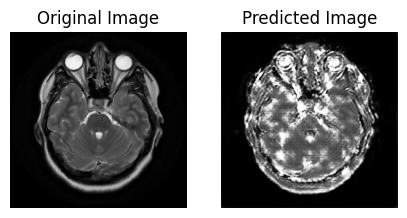

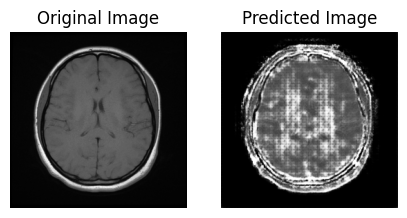

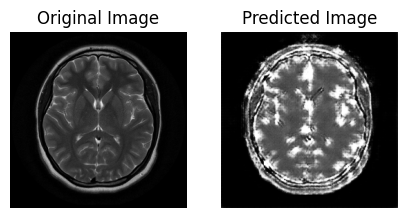

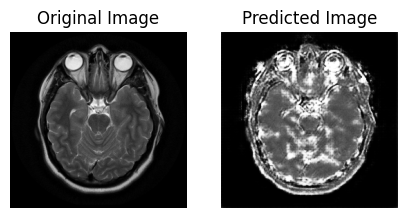

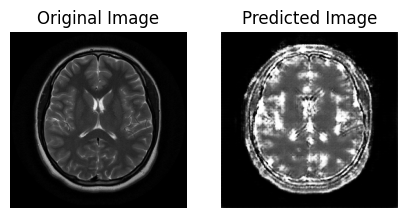

In [90]:
def test_image(img):
    test_image = load_img(img, target_size=(256, 256))
    test_image = img_to_array(test_image)
    test_image = asarray(test_image)
    test_image = tf.image.rgb_to_grayscale(test_image)
    test_image = tf.expand_dims(test_image, axis=0)
    test= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(test_image))
    for p in test.take(1):
        test_model(generator_g, test_image)

for img in images:
    test_image(img)

In [ ]:
# %load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir ./logs/

In [ ]:
shutil.make_archive(TIMESTAMP + '_model_output', 'zip', TEMP_FOLDER)
!rm -rf TEMP_FOLDER